# Helmholtz 1D: Ideal TV & Coarsening for Estimating Relaxation Smoothing

## Goal
Coarrsen 1D Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with constant k using repetitive coarsening.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. 

In this experiment we use a fixed periodic domain with $n=96$ points and a small various $kh$ values. We use the idealized test functions = lowest eigenvectors of $A^h$.

In [209]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Level 0->1 Coarsening
* For various $kh$ values:
* Idealized TV = 2 lowest Eigenvectors.
* Using 10 samples (windows) from each vector.

In [210]:
# Fixed seed for reproducible results.
np.random.seed(0)

n = 96
num_examples = 2
num_windows = 10
threshold = 0.1

kh_values = np.array([0, 0.25, 0.5, 0.7, 1, 2**0.5, 2])
# Exactly 12 gridpoints per wavelength.
#kh = 0.52338538
# Aggregate size must evenly divide the domain size.
aggregate_size_values = np.array([2, 4, 6, 8], dtype=int)
# Mock cycle #relaxations per cycle.
nu_values = np.arange(1, 12, dtype=int)

In [211]:
def ideal_tv(a, num_examples):
    """Returns a test matrix of the 'num_examples' lowest eigenvectors of a and an array of the
    corresponding eigenvalues.
    
    Note: scipy may return complex eigenvectors, but a symmetric matrix always has orthogonal real
    eigenvectors. See https://math.stackexchange.com/questions/47764/can-a-real-symmetric-matrix-have-complex-eigenvectors
    for explanation. 𝐴(𝑎+𝑖𝑏)=𝜆(𝑎+𝑖𝑏)⇒𝐴𝑎=𝜆𝑎  and 𝐴𝑏=𝜆𝑏. Thus we return the real part of v here."""
    lam, v = eig(a.todense())
    lam = np.real(lam)
    v = np.real(v)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    return v[:, :num_examples], lam


def create_coarsening(a, x, num_windows, aggregate_size):
    """Returns a coarsening of a repetitive Helmholtz problem a from windows of the test matrix x."""
    return hm.setup.coarsening.create_coarsening(
        np.concatenate(tuple(hm.linalg.get_window(x, offset, aggregate_size) 
                                     for offset in range(num_windows)), axis=1).transpose(), 
                threshold)


def mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values):
    """Returns a matrix of mock cycle convergence factors (agg size x nu)."""
    return np.array([
        np.array([hm.setup.auto_setup.mock_cycle_conv_factor(
            level, 
            create_coarsening(a, x, num_windows, aggregate_size)[0].tile(level.a.shape[0] // aggregate_size),
            nu) for nu in nu_values])
            for aggregate_size in aggregate_size_values
    ])

def plot_coarsening_result(result):
    kh_values = result.keys()
    fig, axs = plt.subplots(len(kh_values), 5, figsize=(16, 3 * len(kh_values)))
    for row, kh in enumerate(kh_values):
        info = result[kh]
        x, lam, level, mock_conv, nc, aggregate_size, r, s = \
            info["x"], info["lam"], info["level"], info["mock_conv"], info["nc"], info["aggregate_size"], \
            info["r"], info["s"]

        ax = axs[row, 0]
        ax.plot(lam[:20], "rx")
        ax.grid(True)
        ax.set_xlabel("i")
        ax.set_title(r"Eigenvalues $\lambda_i$");
        ax.set_ylabel("kh {:.2f}".format(kh))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        ax.set_title("Test Functions")
        for i, xi in enumerate(x.transpose()):
            ax.plot(xi, label=r"$\lambda = {:.2e}$".format(lam[i]))
        ax.grid(True);

        # R should be real-valued, but cast just in case.
        ax = axs[row, 2]
        for i, ri in enumerate(np.real(r.asarray())):
            ax.plot(ri)
        ax.set_title("R rows, |Agg| {}".format(aggregate_size))
        ax.grid(True);

        ax = axs[row, 3]
        ax.plot(aggregate_size_values, nc / aggregate_size_values, 'o-')
        ax.grid(True);
        ax.set_title("Coarsening Rat. nc {}".format(np.array2string(nc)));
        ax.set_ylabel("CR")
        ax.set_xlabel("Aggregate Size")

        ax = axs[row, 4]
        for aggregate_size, conv in zip(aggregate_size_values, mock_conv):
            ax.plot(nu_values, conv, label="Agg {}".format(aggregate_size))
        ax.legend(loc="upper right");
        ax.set_ylim([0, 1])
        ax.grid(True);
        ax.set_ylabel("Conv Factor")
        ax.set_xlabel(r"$\nu$")
        ax.set_title("Mock Cycle Conv Factor");

In [212]:
result = collections.OrderedDict()
for kh in kh_values:
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
    x, lam = ideal_tv(a, num_examples)
    level = hm.setup.hierarchy.create_finest_level(a)
    mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    aggregate_size = 4
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
    result[kh] = {"x": x, "lam": lam, "level": level, "mock_conv": mock_conv, "nc": nc, 
                  "aggregate_size": aggregate_size, "r": r, "s": s,
                 "coarse_level": coarse_level}

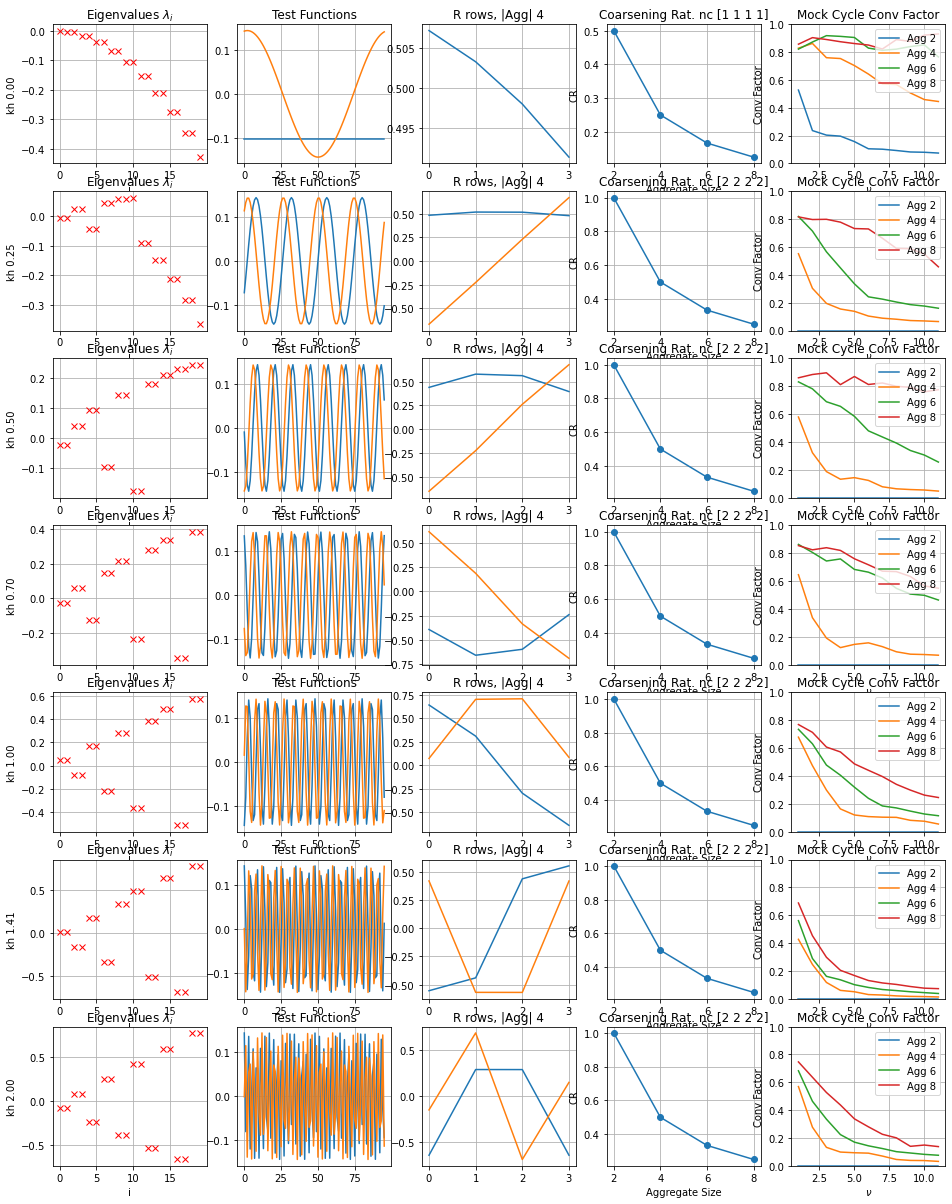

In [213]:
plot_coarsening_result(result)

Looks like the transitional value $kh = 0.5$ poses the largest difficulty (Kaczmarz smoothing is least efficient there), although for aggregate size = 4 (only!) we get a good result there too.

### Example of Intepreting the Coarse Equations for $kh = 0.5$
Interpret the equation via rotation = diagonalization of central block.

In [214]:
kh = 0.5
aggregate_size = 4
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
print("Fine-level stencil")
print(np.array(a.todense()[4:6, 2:8]))

r, s = create_coarsening(a, x, num_windows, aggregate_size)
print("SVD Coarsening")
print(s)
print(r.asarray())

x, lam = ideal_tv(a, num_examples)
level = hm.setup.hierarchy.create_finest_level(a)
mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)

num_aggregates = a.shape[0] // aggregate_size
r_csr = r.tile(num_aggregates)
p_csr = r_csr.transpose()
ac = (r_csr.dot(a)).dot(p_csr)
#print(ac[0].nonzero(), ac[0].data)
print("Coarse-level stencil")
b = np.array(ac[4:6, 2:8].todense())
print(b)
rot = eig(b[:, 2:4])[1]
print("Central block rotation")
print(rot)
print("Is it a rotation? {}".format(norm(rot.dot(rot.transpose()) - np.eye(rot.shape[0])) < 1e-12))
b0, b1, b2 = (rot.transpose().dot(b[:, :2])).dot(rot), (rot.transpose().dot(b[:, 2:4])).dot(rot), (rot.transpose().dot(b[:, 4:6])).dot(rot)
print("After diagonalizing the central block")
print(np.concatenate((b0, b1, b2), axis=1))

print("Diagonalization of neighboring block")
l, v = eig(b0)
print("eigenvalues", l)
print("eigenvectors")
print(v)
print("Is it a rotation? {}".format(norm(v.dot(v.transpose()) - np.eye(v.shape[0])) < 1e-12))

Fine-level stencil
[[-0.08  1.33 -2.25  1.33 -0.08  0.  ]
 [ 0.   -0.08  1.33 -2.25  1.33 -0.08]]
SVD Coarsening
[0.69 0.59 0.   0.  ]
[[-0.64  0.29  0.29 -0.64]
 [-0.15  0.69 -0.69  0.15]]
Coarse-level stencil
[[ 0.59 -0.17 -2.96 -0.    0.59  0.17]
 [ 0.17 -0.05 -0.   -4.11 -0.17 -0.05]]
Central block rotation
[[ 1.  0.]
 [-0.  1.]]
Is it a rotation? True
After diagonalizing the central block
[[ 0.59 -0.17 -2.96 -0.    0.59  0.17]
 [ 0.17 -0.05 -0.   -4.11 -0.17 -0.05]]
Diagonalization of neighboring block
eigenvalues [0.54+0.j 0.  +0.j]
eigenvectors
[[0.96 0.28]
 [0.28 0.96]]
Is it a rotation? False


## Level 1->2 Coarsening
Assuming level 1 was constructed with aggregate size = 4.

In [215]:
result1 = collections.OrderedDict()
for kh in kh_values:
    a = result[kh]["coarse_level"].a
    x, lam = ideal_tv(a, num_examples)
    level = hm.setup.hierarchy.create_finest_level(a)
    mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    aggregate_size = 4
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
    result1[kh] = {"x": x, "lam": lam, "level": level, "mock_conv": mock_conv, "nc": nc, 
                  "aggregate_size": aggregate_size, "r": r, "s": s,
                 "coarse_level": coarse_level}

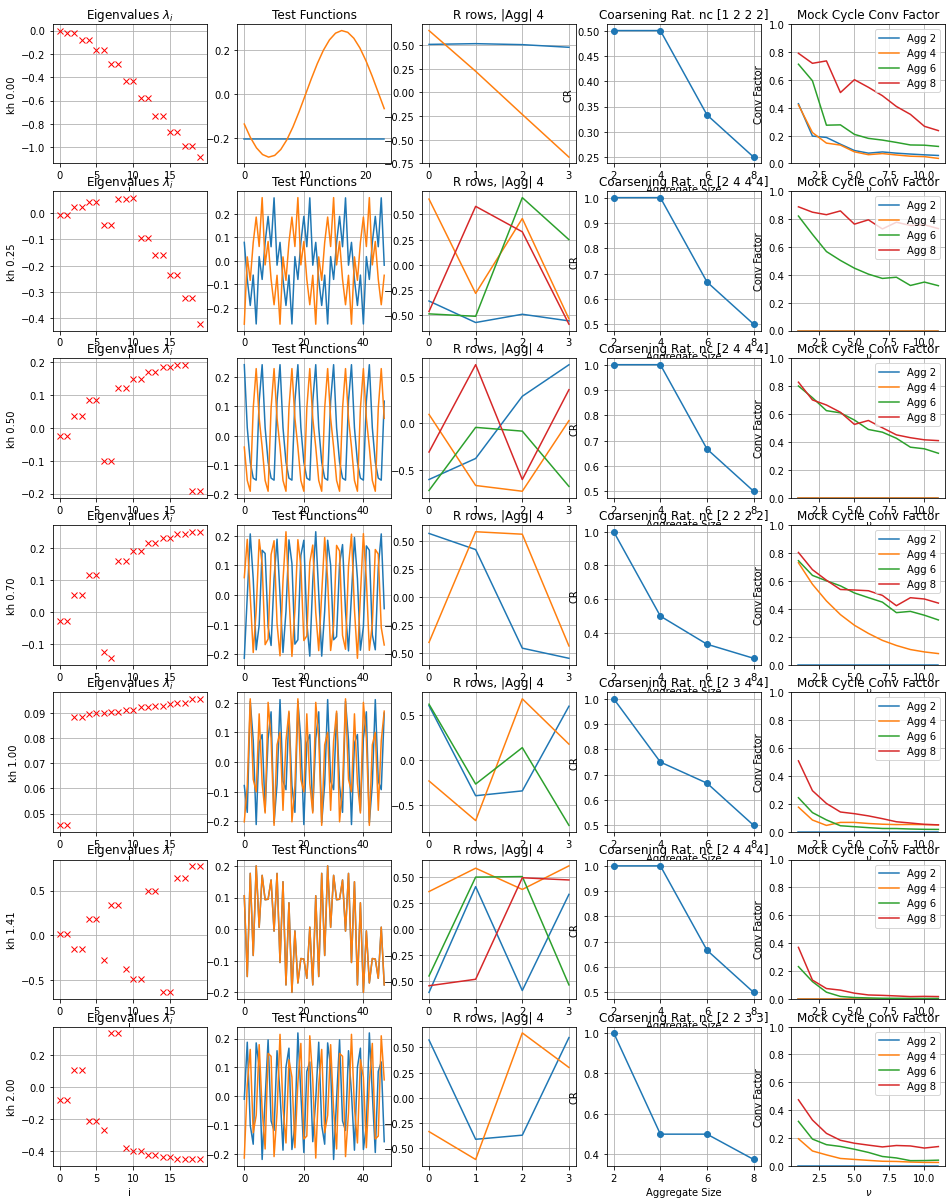

In [216]:
plot_coarsening_result(result1)

Again, $kh = 0.5$ sees the worst Kaczmarz smoothing. We may be able to improve it with block Gauss-Seidel (see below).

## Effect of Level 0 Aggregate Size on Level 1 Singular Values

In [217]:
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
x, lam = ideal_tv(a, num_examples)
level = hm.setup.hierarchy.create_finest_level(a)
agg_sizes = np.array([2, 4, 8]) # At level 1

for aggregate_size in (4, 6, 8):
    print("Level 0 agg size", aggregate_size)
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)

    ac = coarse_level.a
    xc, lam = ideal_tv(ac, num_examples)
    coarse_level = hm.setup.hierarchy.create_finest_level(ac)
    mock_conv = mock_cycle_conv_factor(level, x, agg_sizes, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    print("Mock cycle convergence Factors")
    print(mock_conv)
    print("Aggregate Sizes", agg_sizes)
    print("nc", nc)

    r, s = create_coarsening(ac, xc, num_windows, 4)
    print(r.asarray(), s)

Level 0 agg size 4
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.58 0.32 0.19 0.14 0.13 0.12 0.08 0.06 0.06 0.05 0.05]
 [0.84 0.88 0.87 0.84 0.87 0.78 0.83 0.81 0.8  0.79 0.78]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[-0.61 -0.38  0.29  0.63]
 [ 0.1  -0.67 -0.73  0.03]
 [-0.73 -0.04 -0.08 -0.68]
 [-0.31  0.63 -0.61  0.36]] [0.98 0.76 0.28 0.23]
Level 0 agg size 6
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.56 0.32 0.2  0.13 0.14 0.12 0.08 0.06 0.06 0.05 0.05]
 [0.86 0.91 0.86 0.83 0.82 0.72 0.83 0.8  0.8  0.8  0.78]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[ 0.56  0.44 -0.41 -0.57]
 [-0.4   0.59  0.6  -0.37]] [1.26 1.03 0.08 0.06]
Level 0 agg size 8
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.58 0.32 0.19 0.13 0.14 0.12 0.09 0.06 0.06 0.05 0.05]
 [0.85 0.86 0.9  0.89 0.87 0.84 0.85 0.81 0.75 0.75 0.74]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[ 0.6

Note: we observe Karsten's observation that for aggregate size of 4, there are no clear 2 SVD components at level 1 For size 6, there are just 2 components.

Mock cycle rates are good for any aggregate size at level 0, assuming aggregate size 6 at level 1.

## Comparing Kaczmarz and Block GS Smoothing for Level 1, $kh = 0.5$
Level 1 Formed by Aggregate Size = 4 at Level 0

In [223]:
a = result[kh]["coarse_level"].a
x, lam = ideal_tv(a, num_examples)
level = hm.setup.hierarchy.create_finest_level(a)
aggregate_size = 4
r, s = create_coarsening(a, x, num_windows, aggregate_size)
print(r.asarray(), s)

[[-0.61 -0.38  0.29  0.63]
 [ 0.1  -0.67 -0.73  0.03]
 [-0.73 -0.04 -0.08 -0.68]
 [-0.31  0.63 -0.61  0.36]] [0.98 0.76 0.28 0.23]


### Block GS

In [224]:
m = hm.solve.relax.block_tril(a, 2)

In [225]:
m.todense()[:10,:10]

matrix([[-0.19,  0.04,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.04, -1.49,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.19,  0.35, -0.19,  0.04,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [-0.31, -0.56,  0.04, -1.49,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.19,  0.35, -0.19,  0.04,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  , -0.31, -0.56,  0.04, -1.49,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.19,  0.35, -0.19,  0.04,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  , -0.31, -0.56,  0.04, -1.49,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.19,  0.35, -0.19,  0.04],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.31, -0.56,  0.04, -1.49]])

In [226]:
a.todense()[:10,:10]

matrix([[-0.19,  0.04,  0.19, -0.31,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.04, -1.49,  0.35, -0.56,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.19,  0.35, -0.19,  0.04,  0.19, -0.31,  0.  ,  0.  ,  0.  ,  0.  ],
        [-0.31, -0.56,  0.04, -1.49,  0.35, -0.56,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.19,  0.35, -0.19,  0.04,  0.19, -0.31,  0.  ,  0.  ],
        [ 0.  ,  0.  , -0.31, -0.56,  0.04, -1.49,  0.35, -0.56,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.19,  0.35, -0.19,  0.04,  0.19, -0.31],
        [ 0.  ,  0.  ,  0.  ,  0.  , -0.31, -0.56,  0.04, -1.49,  0.35, -0.56],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.19,  0.35, -0.19,  0.04],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.31, -0.56,  0.04, -1.49]])

In [227]:
mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)
print(mock_conv)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.82 0.73 0.66 0.61 0.54 0.48 0.44 0.41 0.4  0.36 0.32]
 [0.83 0.68 0.64 0.64 0.59 0.56 0.51 0.49 0.46 0.42 0.41]]


In [228]:
level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=2, omega=1))
mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, aggregate_size_values, nu_values)
print(mock_conv_bgs)

[[2.20e-16 1.32e-15 7.34e-15 1.99e-14 1.25e-13 1.11e-12 3.79e-12 2.34e-11 1.04e-10 7.57e-10 1.83e-09]
 [3.83e-16 1.39e-15 7.42e-15 3.67e-14 2.19e-13 7.92e-13 7.14e-12 3.15e-11 2.52e-10 8.69e-10 3.46e-09]
 [5.26e+00 2.42e+01 1.56e+02 8.73e+02 4.71e+03 2.51e+04 1.38e+05 7.50e+05 4.06e+06 2.22e+07 1.20e+08]
 [4.85e+00 2.49e+01 1.26e+02 7.53e+02 4.26e+03 2.27e+04 6.16e+04 6.64e+05 3.64e+06 1.98e+07 1.07e+08]]


Looks like Block GS diverges. Let's check first for Poisson.

### Sanity Check: Block GS Mock Cycle Convergence for Poisson
For aggregate sizes 2, 4, 6, vs. $\nu=1,\dots,5$.

In [202]:
# a = hm.linalg.helmholtz_1d_5_point_operator(0.0, n).tocsr()
# x, lam = ideal_tv(a, num_examples)

# print("Kaczmarz")
# level = hm.setup.hierarchy.create_finest_level(a)
# print(mock_cycle_conv_factor(level, x, [2, 4, 6], nu_values))

# print("GS")
# level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=1))
# mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, [2, 4, 6], nu_values)
# print(mock_conv_bgs)

# print("GS, block size 2")
# level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=2))
# mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, [2, 4, 6], nu_values)
# print(mock_conv_bgs)

OK, at least in this case we have BGS reasonable convergence (for aggregate size = 2).

## Strength of connection at level 1

In [271]:
print(a.shape)
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x)
x, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x,num_sweeps=100, print_frequency=1)
print("Relax convergence factor {:.3f}".format(relax_conv_factor))
print("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))

(48, 48)
INFO         0 |r| 9.09982680e-01 RER 1.27347
INFO         1 |r| 2.95498807e-01 (0.32473) RER 0.59573 (0.46780) 0.49603
INFO         2 |r| 2.24586185e-01 (0.76002) RER 0.51920 (0.87154) 0.43256
INFO         3 |r| 1.81456176e-01 (0.80796) RER 0.46250 (0.89079) 0.39234
INFO         4 |r| 1.51135031e-01 (0.83290) RER 0.41753 (0.90278) 0.36197
INFO         5 |r| 1.26995061e-01 (0.84028) RER 0.37506 (0.89827) 0.33860
INFO         6 |r| 1.07959100e-01 (0.85010) RER 0.33682 (0.89806) 0.32052
INFO         7 |r| 9.28653685e-02 (0.86019) RER 0.30315 (0.90002) 0.30634
INFO         8 |r| 8.08467347e-02 (0.87058) RER 0.27404 (0.90397) 0.29502
INFO         9 |r| 7.12232844e-02 (0.88097) RER 0.24918 (0.90930) 0.28583
INFO        10 |r| 6.34661098e-02 (0.89109) RER 0.22812 (0.91546) 0.27822
INFO        11 |r| 5.71654505e-02 (0.90072) RER 0.21032 (0.92197) 0.27181
INFO        12 |r| 5.20040700e-02 (0.90971) RER 0.19527 (0.92847) 0.26632
INFO        13 |r| 4.77371791e-02 (0.91795) RER 0.18252 (

In [269]:
aggregate_size = 10
y = np.concatenate(tuple(hm.linalg.get_window(x, offset, aggregate_size) 
                     for offset in range(num_windows)), axis=1).transpose()
z = y / norm(y, axis=0)

In [270]:
cos_distance = np.abs(z.transpose().dot(z))
print(cos_distance)

[[1.   0.4  0.46 0.79 0.61 0.38 0.99 0.47 0.35 0.77]
 [0.4  1.   0.4  0.4  0.76 0.52 0.32 0.99 0.46 0.3 ]
 [0.46 0.4  1.   0.47 0.42 0.8  0.56 0.33 0.99 0.52]
 [0.79 0.4  0.47 1.   0.37 0.57 0.79 0.51 0.41 0.99]
 [0.61 0.76 0.42 0.37 1.   0.33 0.51 0.77 0.52 0.32]
 [0.38 0.52 0.8  0.57 0.33 1.   0.45 0.41 0.8  0.65]
 [0.99 0.32 0.56 0.79 0.51 0.45 1.   0.4  0.46 0.79]
 [0.47 0.99 0.33 0.51 0.77 0.41 0.4  1.   0.39 0.42]
 [0.35 0.46 0.99 0.41 0.52 0.8  0.46 0.39 1.   0.46]
 [0.77 0.3  0.52 0.99 0.32 0.65 0.79 0.42 0.46 1.  ]]


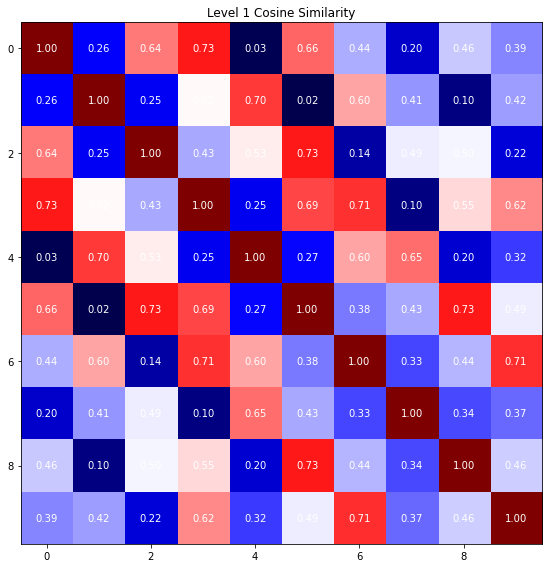

In [266]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cos_distance, plt.get_cmap("seismic"))

# Loop over data dimensions and create text annotations.
for i in range(cos_distance.shape[0]):
    for j in range(cos_distance.shape[1]):
        text = ax.text(j, i, "{:.2f}".format(cos_distance[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Level 1 Cosine Similarity")
fig.tight_layout()
plt.show()